# Attempt to use cpDistiller

In [1]:
import scanpy as sc
import anndata as ad
from cpDistiller import DataSet,labeled,cpDistiller_Model,merge_csv2h5ad,merge_csv,scale_batch
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, fcluster
warnings.filterwarnings("ignore")

In [2]:
adata_orig = ad.read_h5ad("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/mad_int_featselect_all_methods.h5ad")
adata_orig

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'
    obsm: 'combat', 'cpDistiller', 'desc', 'fastMNN', 'gaushanvi', 'gaushvi', 'harmony', 'scanorama', 'scanorama_pca', 'scanvi', 'scpoli', 'scvi', 'seurat_cca', 'seurat_rpca', 'sphering', 'sysvi'

## Correct for Batch

In [4]:
adata_batch = adata_orig.copy()
adata_batch.obs = adata_batch.obs.rename(columns={
    "Metadata_Batch": "batch",
    "Metadata_Row": "row",
    "Metadata_Column": "col",
})

scale_batch(adata_batch)
sc.pp.scale(adata_batch)
dat = DataSet(adata_batch, batch_size=256, mod=1)
labeled(adata_batch, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller =  cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

View of AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'batch', 'Metadata_PlateType', 'Metadata_PertType', 'row', 'col', 'Metadata_Microscope'

In [9]:
cpDistiller.train()
cpDistiller.ema.apply()
result_batch, category = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-24 02:21:15,843 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [11]:
batch_result_df = pd.DataFrame(result_batch)
batch_result_df.columns = [f"cpDistiller_{i}" for i in range(batch_result_df.shape[1])]
batch_result_df.index = adata_batch.obs.index
batch_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-2.299724,0.922525,-1.875517,-2.768439,1.105904,2.720570,3.262518,0.619583,1.726743,-0.197782,...,2.422776,2.567023,3.033813,-0.082915,2.897596,-2.192385,-3.508528,2.878288,2.462256,2.431266
1,-2.486204,-0.815539,4.256042,-0.853184,2.302033,-7.335078,-0.707817,-0.150003,-0.836733,-2.197092,...,2.798357,2.262217,1.982693,-1.507384,4.630120,-2.389736,-1.703045,4.523862,1.368968,1.973226
2,-2.881653,0.923733,-1.472091,-3.172742,4.931019,-2.054513,-0.953762,0.742082,-0.761785,-3.018736,...,2.278850,3.603863,-1.063655,-1.770256,2.538977,-2.791566,-3.139166,1.843200,1.539326,1.974415
3,-2.645350,-1.868895,2.468789,-2.901409,1.733664,-5.204628,1.110184,-0.426285,-1.116295,-3.254824,...,3.306729,2.373161,0.436244,-1.293067,2.219831,-2.887938,-1.855665,2.713530,3.341138,3.020866
4,-4.760606,-0.203520,-1.462765,-3.126326,4.923601,-4.151960,-0.349030,2.853509,2.080640,-1.842171,...,2.861851,3.290174,0.122454,0.881740,2.252629,-2.202995,-3.405320,3.259299,1.890997,2.408418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-3.073117,-1.305425,-0.994813,-0.151588,0.146500,-2.191128,3.971485,1.964388,-0.532372,-2.836130,...,3.426253,3.404299,-2.700646,-0.540839,2.574094,-3.227332,-1.328715,1.553631,1.893355,3.333817
25325,-1.993951,1.302046,-0.940844,-3.097832,6.815118,-1.457289,0.486598,1.155256,-2.776855,-2.531503,...,-0.217210,2.913664,-0.995188,-1.313050,3.641585,-3.059000,-1.485506,2.138966,1.873867,2.811330
25326,-4.515196,-0.257368,2.794110,-3.511798,4.295984,-5.557358,-0.001762,-0.027234,-1.210023,-2.996703,...,3.569218,3.166459,1.754632,-3.561055,1.497154,-2.565587,-2.152073,-0.318129,2.637304,3.168765
25327,-4.531614,-0.126879,0.221169,-2.778843,4.816784,-3.646440,2.906363,-0.254096,-2.190734,-1.316390,...,2.353236,1.928082,3.498746,-0.686000,3.208437,-1.282184,-2.111631,2.275618,2.436826,2.456876


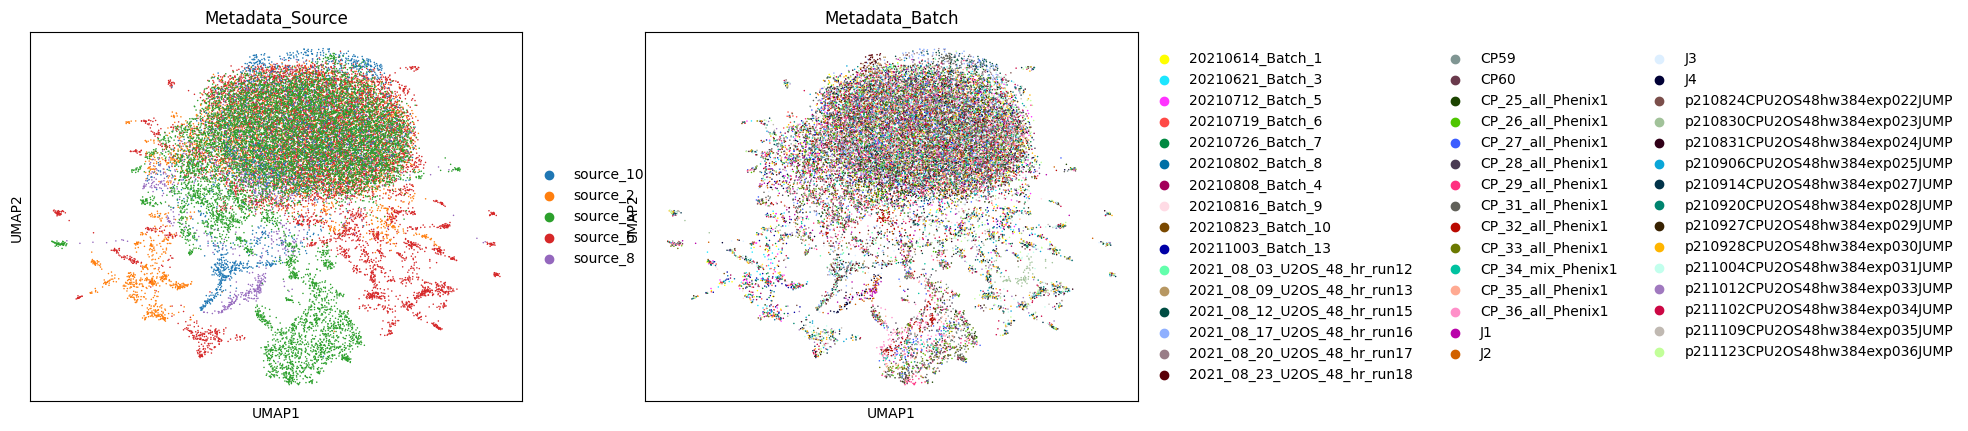

In [14]:
adata_cpdist = ad.AnnData(batch_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_cpdist)
sc.tl.umap(adata_cpdist)
sc.pl.umap(adata_cpdist, color=["Metadata_Source", "Metadata_Batch"])

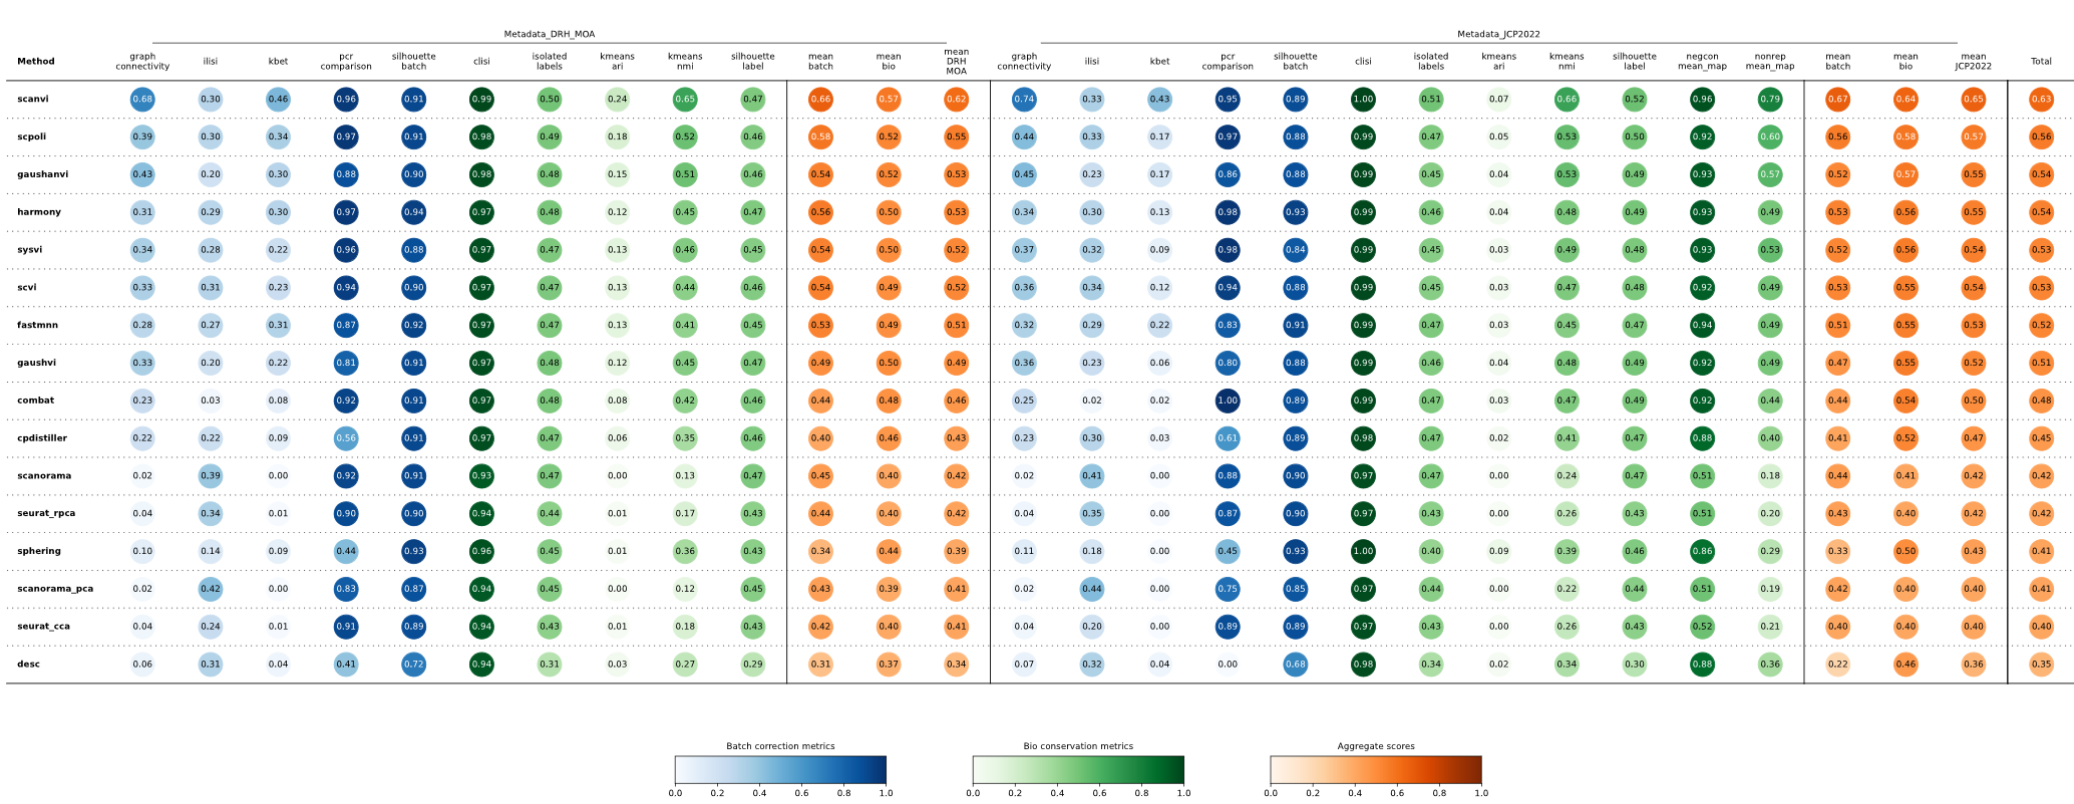

## Correct for Source

In [19]:
adata_source = adata_orig.copy()
adata_source.obs = adata_source.obs.rename(columns={
    "Metadata_Source": "batch",
    "Metadata_Row": "row",
    "Metadata_Column": "col",
})

scale_batch(adata_source)
sc.pp.scale(adata_source)
dat = DataSet(adata_source, batch_size=256, mod=1)
labeled(adata_source, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller =  cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

2025-01-24 02:40:32,941 - INFO - MNN pairs num: 688580
2025-01-24 02:40:42,774 - INFO - KNN pairs num: 263665


In [20]:
cpDistiller.train()
cpDistiller.ema.apply()
source_result, category = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-24 02:41:48,143 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [24]:
source_result_df = pd.DataFrame(source_result)
source_result_df.columns = [f"cpDistiller_{i}" for i in range(source_result_df.shape[1])]
source_result_df.index = adata_source.obs.index
source_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-1.385598,-4.700715,2.915752,0.622259,4.146342,-5.000999,0.678582,1.011764,1.683799,-2.011402,...,-0.237998,2.744430,1.000566,-3.946132,-0.431181,-1.680896,1.317230,1.891412,1.279697,1.848010
1,0.139119,-2.138427,1.814179,-1.274385,0.142397,-0.323401,2.558490,-1.238020,5.523767,-2.364149,...,0.256274,1.635319,-0.765474,0.066128,-1.833215,-2.624151,2.167061,1.048693,1.515095,1.653981
2,-2.154329,2.555989,0.784129,-1.206165,2.491330,-0.921110,0.545604,0.221103,0.347848,-1.266123,...,0.852170,2.197768,0.916499,0.359429,0.015692,-1.311123,-1.257434,0.692083,0.815471,0.489795
3,-1.301827,-1.449160,3.469365,-0.509374,0.604965,-0.240442,0.133340,-2.787967,3.913988,-2.220750,...,1.487415,2.123128,0.641690,-2.205496,0.054971,-1.627067,-2.105619,1.577800,1.858109,1.400659
4,-1.002682,-0.769027,0.552510,-3.082233,2.856773,-3.189781,0.476086,2.564314,3.508760,-1.680359,...,-0.150707,2.491451,1.234227,-0.634860,-2.320177,-2.119790,0.264560,2.330376,2.496942,2.805651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-3.831380,-1.467328,-1.057823,-0.277835,5.907609,-3.623644,1.294760,1.186666,2.080862,-1.752198,...,0.678623,2.270887,-1.644854,-1.120033,-0.402379,-2.797025,-0.638792,1.446337,3.083448,1.685238
25325,-1.378809,3.691360,-0.393183,-1.397700,3.705987,-1.198000,1.481045,-0.031107,-2.292125,-1.234670,...,2.936782,0.610565,3.818873,-2.664040,-0.181761,-1.160118,-1.017532,-0.904643,2.058059,1.171644
25326,-1.618054,1.720482,-1.026638,-3.017819,-0.225376,-0.609862,1.986556,-0.771128,1.162431,-2.702935,...,0.833319,1.046142,0.341973,0.116066,1.136534,-1.184561,-0.042676,1.097192,0.750470,3.667048
25327,-1.680307,-3.117285,1.830022,-1.185672,0.474474,-0.985727,0.721464,-0.449901,-0.340167,-0.409458,...,0.449094,2.142107,0.420999,-0.837836,-0.612706,-1.887254,0.050212,1.805439,1.693615,2.059833


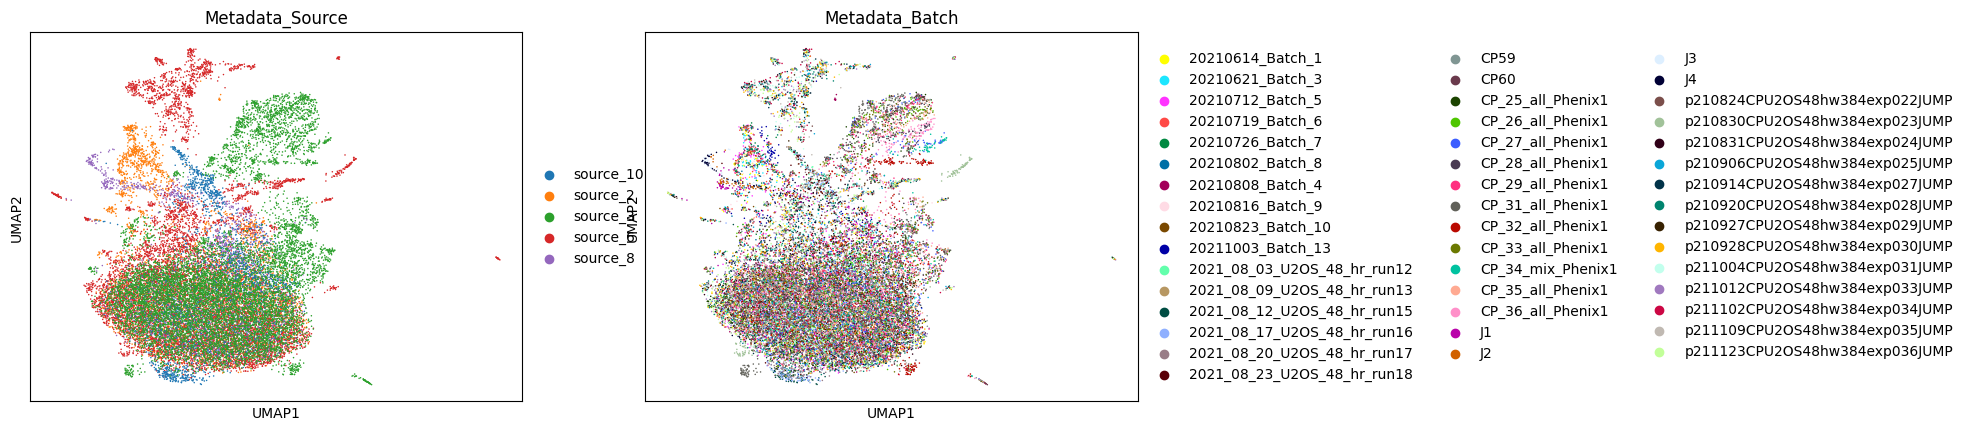

In [25]:
adata_cpdist = ad.AnnData(source_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_cpdist)
sc.tl.umap(adata_cpdist)
sc.pl.umap(adata_cpdist, color=["Metadata_Source", "Metadata_Batch"])

## Correct for Source, Batch, Plate

In [26]:
adata_source_batch_plate = adata_orig.copy()
adata_source_batch_plate.obs = adata_source_batch_plate.obs.rename(columns={
    "Metadata_Source": "batch",
    "Metadata_Batch": "row",
    "Metadata_Plate": "col",
})

scale_batch(adata_source_batch_plate)
sc.pp.scale(adata_source_batch_plate)
dat = DataSet(adata_source_batch_plate, batch_size=256, mod=1)
labeled(adata_source_batch_plate, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller =  cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

2025-01-24 03:03:03,277 - INFO - MNN pairs num: 1831918
2025-01-24 03:03:35,269 - INFO - KNN pairs num: 266464


In [27]:
cpDistiller.train()
cpDistiller.ema.apply()
source_result, category = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-24 03:04:52,389 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [28]:
source_batch_plate_result_df = pd.DataFrame(source_result)
source_batch_plate_result_df.columns = [f"cpDistiller_{i}" for i in range(source_batch_plate_result_df.shape[1])]
source_batch_plate_result_df.index = adata_source.obs.index
source_batch_plate_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-3.695390,1.107548,-0.700770,-1.441343,0.485128,2.560196,-2.963863,-2.042217,3.646436,4.456021,...,3.845617,-2.226555,0.918325,-1.398586,-2.541493,-2.237203,-0.629992,0.039107,-2.256713,4.779116
1,3.448349,1.614721,2.032660,-1.353574,3.185266,1.641479,-2.712501,-3.444298,3.324904,0.822105,...,0.277600,1.968062,-1.137038,-1.785041,-1.779664,1.841792,-1.128909,0.886707,-2.914467,2.275524
2,1.318326,1.016253,0.936832,1.149127,1.243706,-0.772200,-1.933170,0.341712,1.233460,2.357763,...,2.317684,-3.422290,0.476345,-2.737334,-0.579114,-1.380816,0.074886,1.278939,-0.990934,-2.389923
3,-0.996119,1.436298,-1.924659,0.038926,4.103750,0.757909,-3.178613,-6.393556,1.870700,-0.307514,...,1.013967,2.584359,0.104594,-2.293457,-2.555465,2.950294,-1.637286,1.113966,-3.551487,1.443830
4,3.575993,0.937595,4.477711,-0.747917,-0.067973,1.494345,-1.718146,-1.140295,1.650694,4.199166,...,1.015635,-3.574511,1.653542,-0.886886,-0.494532,-1.009477,-0.483621,0.967751,-1.915910,-2.447508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-0.880139,0.431321,1.869450,-0.376146,1.951229,-1.450041,-2.035403,-0.617995,1.558530,2.207319,...,0.238943,-1.335029,-0.109975,-2.497596,0.753684,-1.712112,-1.135296,2.311352,-1.141338,0.104302
25325,4.200727,0.968313,2.300101,0.709752,0.651022,-0.647049,-0.745132,-0.831310,3.443834,-0.533409,...,2.723057,-4.813004,1.422067,-1.914454,-1.996571,-0.293307,-1.208788,2.343986,-3.461449,0.365543
25326,3.924150,1.584646,1.021557,0.975730,-0.935168,-1.818267,-1.700547,-1.592057,2.922479,1.827346,...,0.373240,1.238268,0.805235,-1.320098,-1.487878,1.272818,-1.753592,0.758068,-2.406615,-2.346518
25327,-0.627565,1.670732,0.854449,-0.020393,3.352702,0.699947,-1.843687,-4.176970,2.876921,1.552217,...,2.544003,-1.524035,-0.709828,-2.937328,-1.007357,0.676159,-0.053695,1.251434,-1.992859,2.608984


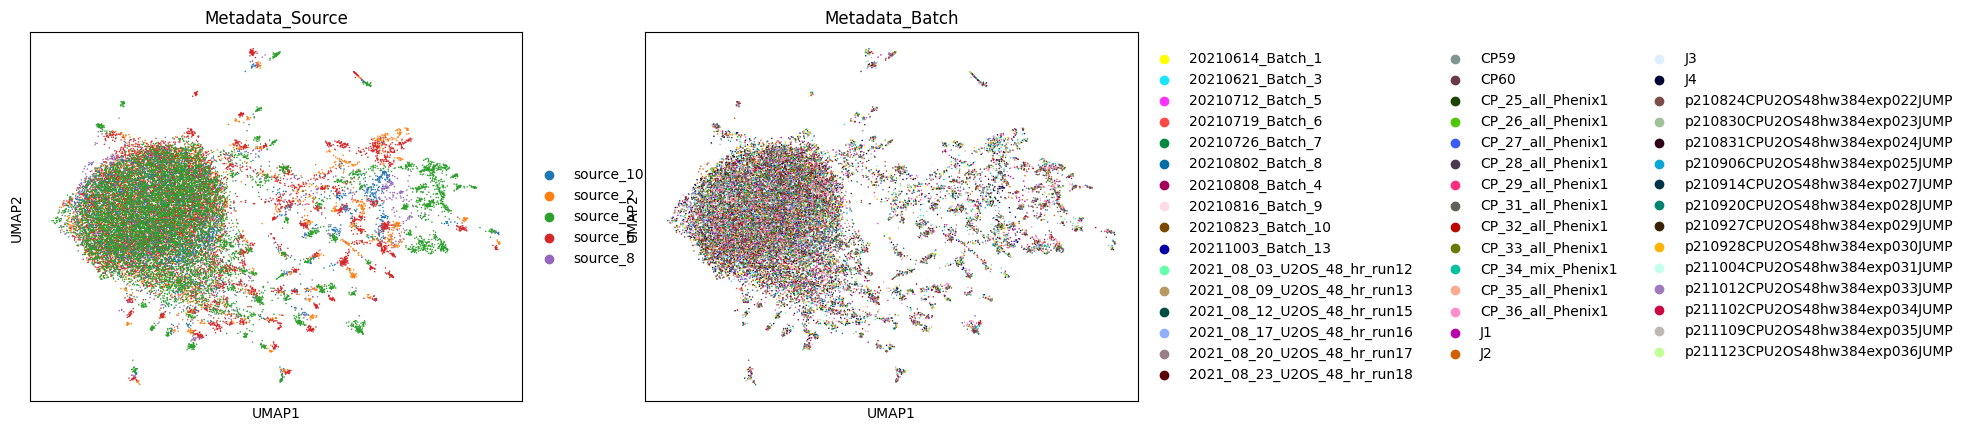

In [29]:
adata_cpdist = ad.AnnData(source_batch_plate_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_cpdist)
sc.tl.umap(adata_cpdist)
sc.pl.umap(adata_cpdist, color=["Metadata_Source", "Metadata_Batch"])

## Optionally write to anndata for the benchmark

In [45]:
adata_orig.obsm["cpDistiller"] = ...

In [46]:
adata_orig.write_h5ad("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/mad_int_featselect_all_methods.h5ad")